In [ ]:
jupyterlab_url = "http://localhost:8888/lab?token=test-token"
default_result_path = None
close_on_fail = False
transition_timeout = 10000
default_delay = None

In [115]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmp__6y4z2u'

# nbsearch E2E Test - Cell Search on JupyterLab

- Test data to prepare: Test notebooks should be indexed in Solr
- Tests Cell Search using %%nbsearch magic command on JupyterLab interface

In [ ]:
import asyncio
import importlib

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path, delay=default_delay)

## Open JupyterLab and create new notebook

Start epoch: 1761016584.365037 seconds


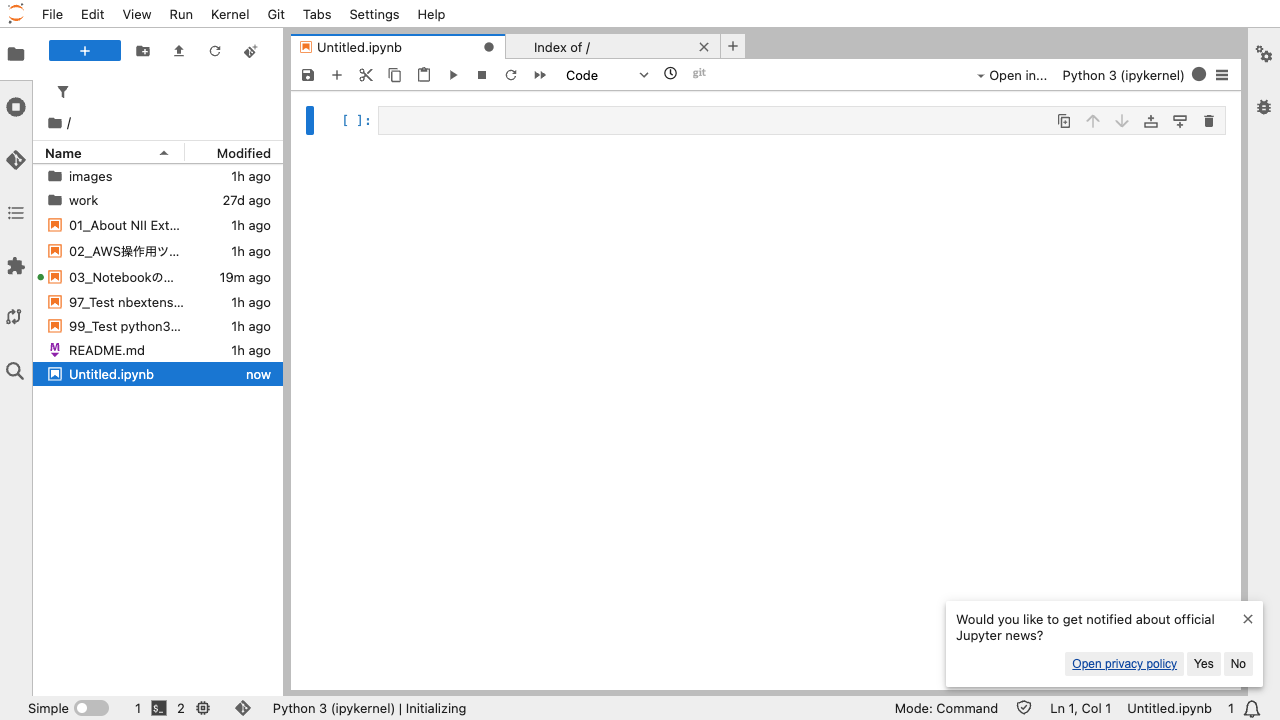

In [123]:
async def _step(page):
    await page.goto(jupyterlab_url)

    # Wait for JupyterLab to load
    await expect(page.locator('#jp-main-dock-panel')).to_be_visible(timeout=transition_timeout)

    # Click on "Launcher" tab
    await page.locator('//*[contains(@class, "lm-TabBar-tabLabel") and text() = "Launcher"]').click()
    
    # Click on "Python 3" notebook
    await page.locator('.jp-Launcher-section').first.locator('//img[@alt="Python 3 (ipykernel)" and @class="jp-Launcher-kernelIcon"]').click()
    
    # Wait for notebook to be ready
    await expect(page.locator('.jp-Cell')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Load nbsearch magic extension

Start epoch: 1761016586.9317079 seconds


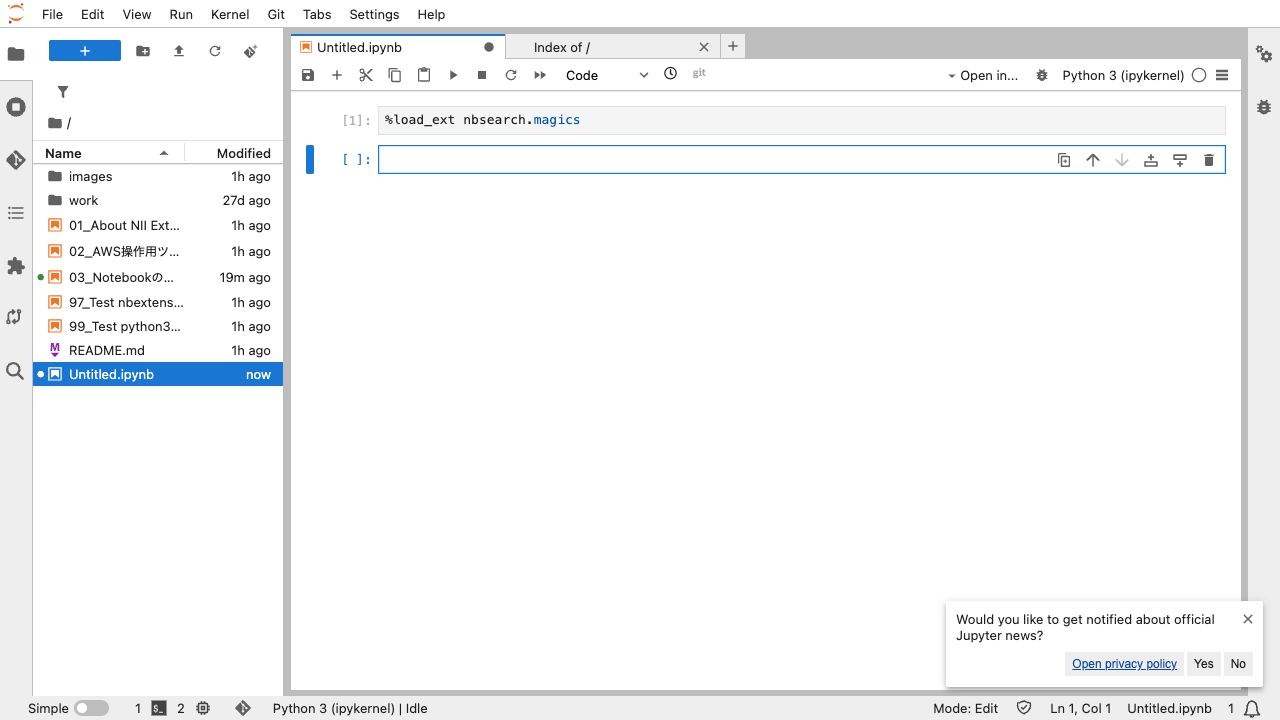

In [124]:
async def _step(page):
    # Type %load_ext nbsearch.magics in the first cell
    cell = page.locator('.jp-Cell-inputArea .cm-content').first
    await cell.click()
    await cell.type('%load_ext nbsearch.magics')
    
    # Execute the cell (Shift+Enter)
    await page.keyboard.press('Shift+Enter')
    
    # Wait for cell execution to complete
    await page.wait_for_timeout(2000)

await run_pw(_step)

## Execute %%nbsearch magic command

Start epoch: 1761016589.223449 seconds


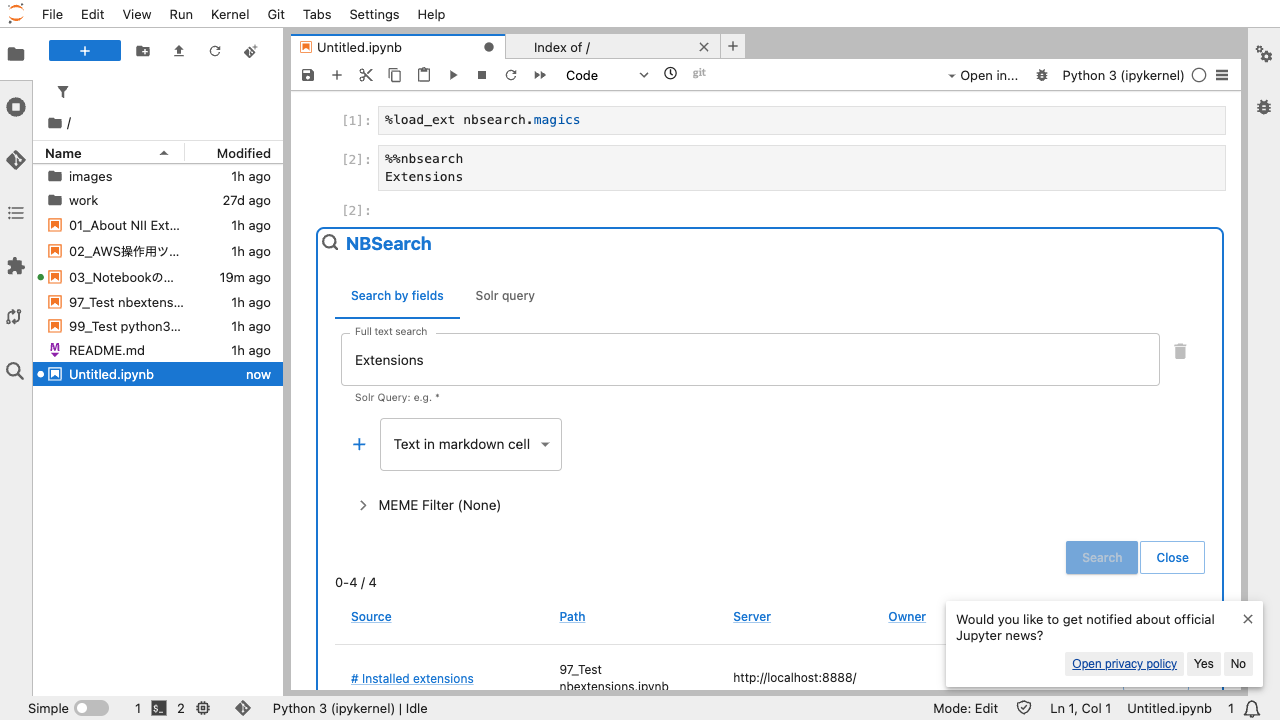

In [ ]:
async def _step(page):
    # The second cell should be selected automatically after Shift+Enter
    # Type %%nbsearch magic command with a simple query
    cell = page.locator('.jp-Cell.jp-mod-selected .cm-content')
    await cell.type('%%nbsearch\nExtensions')
    
    # Execute the cell
    await page.keyboard.press('Shift+Enter')
    await asyncio.sleep(1)
    
    # Wait for magic search widget to appear in the cell output
    await page.locator('.nbsearch-magic-root').scroll_into_view_if_needed()
    await expect(page.locator('.nbsearch-magic-root').locator('//*[contains(text(), "Add")]').first).to_be_visible(timeout=transition_timeout)
    await asyncio.sleep(1)

await run_pw(_step)

## Click "Add" button in the search results and click "Containing section" option

Start epoch: 1761016592.0102642 seconds


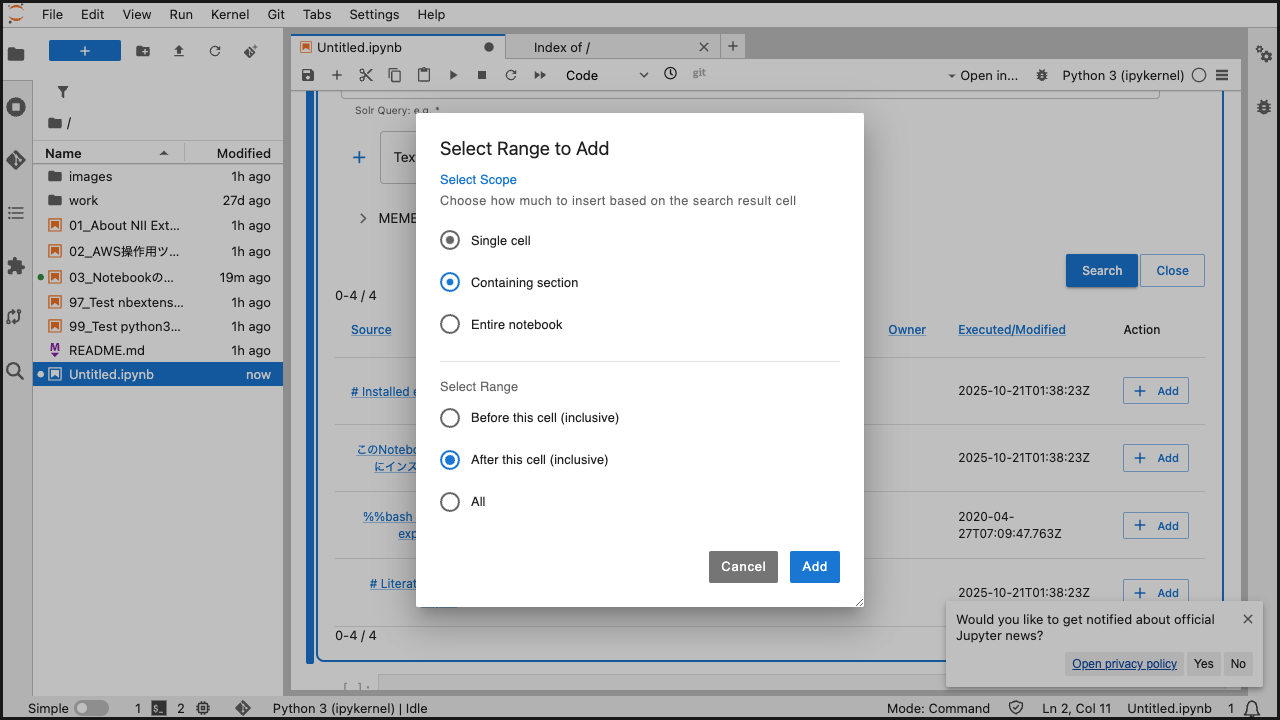

In [ ]:
async def _step(page):
    await page.locator('.nbsearch-magic-root').locator('//*[contains(text(), "Add")]').first.click()
    await asyncio.sleep(0.2)

    # Click the "Containing section" label
    await page.locator('//*[text()="Containing section"]').click()
    await asyncio.sleep(0.2)

    # Verify the "Select Range" options appear
    await expect(page.locator('//*[text()="Select Range"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Click "Add" button and verify the cells are added

Start epoch: 1761016750.732657 seconds


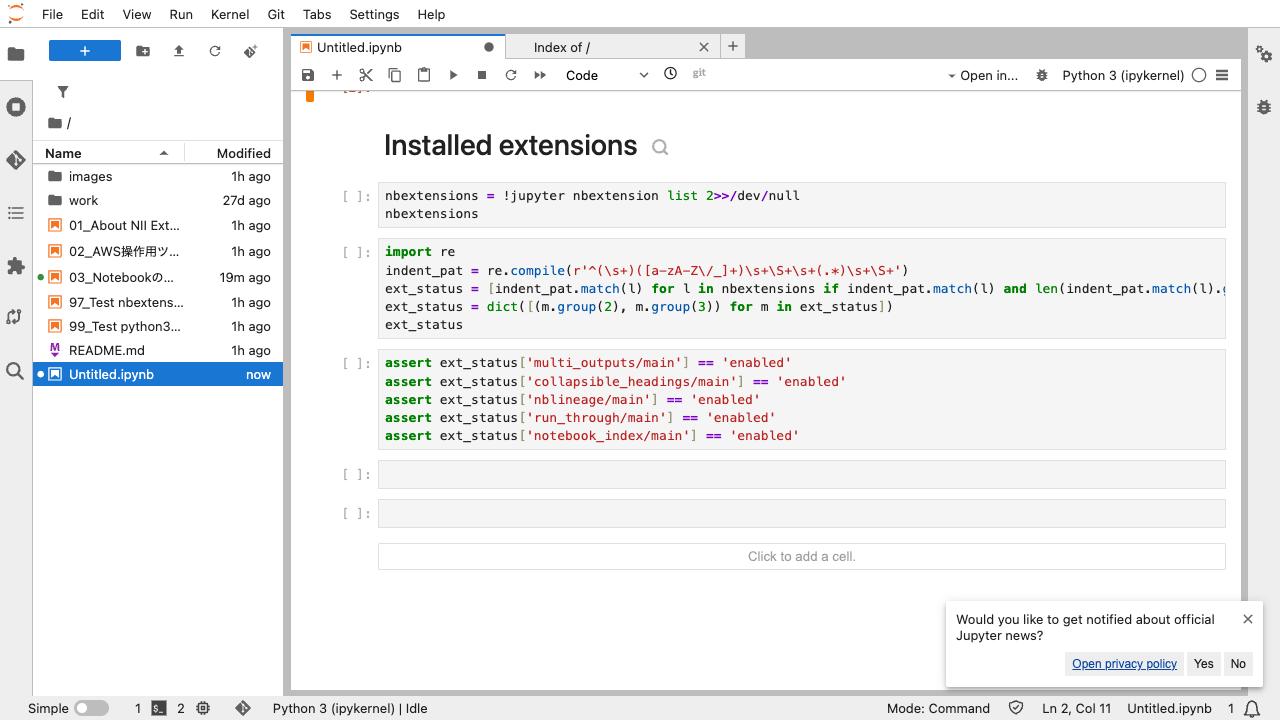

In [127]:
async def _step(page):
    # Count the number of cells before insertion
    cells = page.locator('.jp-Cell')
    initial_cell_count = await cells.count()

    # Click <div class="jp-Dialog-buttonLabel" title="" aria-label="Add">Add</div>
    await page.locator('//div[@class="jp-Dialog-buttonLabel" and text()="Add"]').click()

    # Verify that new cells are added
    await expect(page.locator('.jp-Cell')).not_to_have_count(initial_cell_count, timeout=transition_timeout)

    after_cell_count = await cells.count()
    assert after_cell_count > initial_cell_count, "No new cells were added."    

await run_pw(_step)

## Clean up

In [ ]:
await finish_pw_context()

In [ ]:
!rm -fr {work_dir}